In [1]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

import time
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
np.random.seed(0)
df = pd.read_csv("../../Data/dataset2/train.csv")

df.dropna(inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)
drop_indices = np.random.choice(np.arange(0, df.shape[0], 1), 350, replace=False)
df.drop(drop_indices, inplace=True)
X = df.drop(columns=['price_range'])
y = df[['price_range']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
df[['price_range']].value_counts()

price_range
1              419
0              417
2              416
3              398
dtype: int64

In [4]:
# preventing information about the distribution of the test set leaking into your model
standard_scaler = MinMaxScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.fit_transform(x_test)
y_train_scaled = standard_scaler.fit_transform(y_train).astype('int')
y_test_scaled = standard_scaler.fit_transform(y_test).astype('int')
len(y_train_scaled)

1320

In [5]:
# x_train_scaled = x_train
# x_test_scaled = x_test
# y_train_scaled = y_train
# y_test_scaled = y_test

In [6]:
clf = SVC()
start_time = time.time()
clf.fit(x_train_scaled, y_train_scaled)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test_scaled)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred)}")
print(classification_report(y_test_scaled, y_pred))

KNN Normal Model: Fit Time: 0.028463363647460938
KNN Normal Model: Fit Time: 0.00521540641784668
Score of Model Tree are (Mean Accuracy of test and train data): 0.9545454545454546
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       254
           1       0.93      0.87      0.90        76

    accuracy                           0.95       330
   macro avg       0.95      0.92      0.93       330
weighted avg       0.95      0.95      0.95       330



In [7]:
param_range = np.logspace(-1, 4, 10)

param = "C"
classifier = "KNN"
train_scores, test_scores = validation_curve(clf, x_train_scaled, y_train_scaled, param_name=param, param_range=param_range, cv=5, n_jobs=-1, scoring="accuracy")

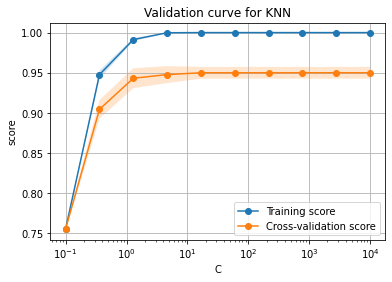

In [8]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
depth_range_list = param_range

plt.semilogx(depth_range_list, mean_train_scores, 'o-', label='Training score')
plt.semilogx(depth_range_list, mean_test_scores, 'o-', label='Cross-validation score')

plt.fill_between(depth_range_list, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.fill_between(depth_range_list, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)

plt.title(f'Validation curve for {classifier}')
plt.xlabel(param)
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()

#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

In [9]:
### PIPELINES ###
# Data scaled in pipeline already
pipeline = make_pipeline(MinMaxScaler(), SelectFromModel(RandomForestClassifier()), SVC())
pipeline.fit(x_train_scaled, y_train_scaled)
print(f"MLP Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline = pipeline.predict(x_test_scaled)
print(f"MLP Pipeline Model: Predict Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred_pipeline)}")
print(classification_report(y_test_scaled, y_pred_pipeline))

MLP Pipeline Model: Fit Time: 2.009996175765991
MLP Pipeline Model: Predict Time: 0.007457733154296875
Score of Model Tree are (Mean Accuracy of test and train data): 0.9696969696969697
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       254
           1       0.91      0.96      0.94        76

    accuracy                           0.97       330
   macro avg       0.95      0.97      0.96       330
weighted avg       0.97      0.97      0.97       330



In [10]:
### TUNING ####
d = x_train.shape[1]
param = {'svc__C': np.logspace(-2, 4, 100),
        }
clf_cv = GridSearchCV(pipeline, n_jobs=-1, param_grid=param, refit=True, cv=6, return_train_score=True, verbose=1)
start_time = time.time()
clf_cv = clf_cv.fit(x_train_scaled, np.ravel(y_train_scaled))
print(f"MLP CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test_scaled)
print(f"MLP CV Model: Predict Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred_pipeline_cv)}")
print(classification_report(np.ravel(y_test_scaled), y_pred_pipeline_cv))

Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    1.5s


MLP CV Model: Fit Time: 3.052706241607666
MLP CV Model: Predict Time: 0.006731986999511719
Score of Model Tree are (Mean Accuracy of test and train data): 0.9636363636363636
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       254
           1       0.89      0.96      0.92        76

    accuracy                           0.96       330
   macro avg       0.94      0.96      0.95       330
weighted avg       0.97      0.96      0.96       330



[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.9s finished


In [11]:
clf_cv.best_params_

{'svc__C': 8.111308307896872}

In [12]:
train_sizes = np.arange(0.1, 1.0, 0.1)
clf_new = SVC(C=705.4802310718645)
_, train_scores, test_scores = learning_curve(clf_new, x_train, np.ravel(y_train), train_sizes=train_sizes, cv=5)

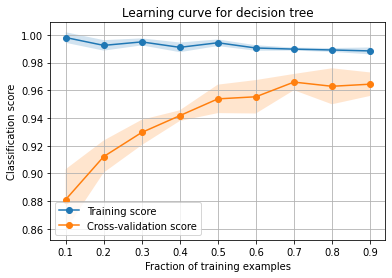

In [13]:
plt.figure()
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training score')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(train_sizes, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

In [14]:
lw = 2
params = np.logspace(-2, 4, 100)
clf_score_list = []
fit_time_list = []
predict_time_list = []
main_start_time = time.time()
for i in params:
    clf = SVC(C=i)
    start_time = time.time()
    clf.fit(x_train_scaled, y_train_scaled)
    clf_score_list.append(clf.score(x_test_scaled, y_test_scaled))
    
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
    
    start_time = time.time()
    y_pred = clf.predict(x_test_scaled)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)
    
print(f"Entire cell took {time.time() - main_start_time}")

Entire cell took 3.624410629272461


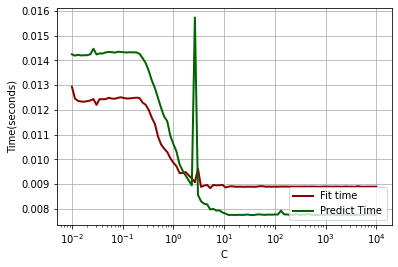

In [15]:
def normalize_data_points(points):
    return [float(i)/sum(points) for i in points]

lw = 2
param_list = params
# param_list = np.arange(0, len([(h,)*l for l in [1,2,3,4,5] for h in [d,d//2,d*2]]))
plt.semilogx(param_list, normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
plt.semilogx(param_list, normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)

plt.xlabel('C')
plt.ylabel("Time(seconds)")
# plt.xticks(np.arange(1, len(param_list), 2.0))
# plt.yticks(np.arange(min(predict_time_list), max(fit_time_list), 0.004))
plt.grid()
plt.legend(loc='lower right')

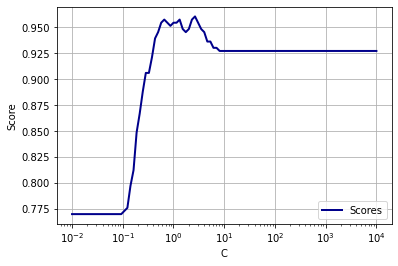

In [17]:
lw = 2
plt.semilogx(param_list, clf_score_list, label="Scores", color="darkblue", lw=lw)
plt.xlabel('C')
plt.ylabel("Score")
plt.grid()
plt.legend(loc='lower right')